In [64]:
# Source reference to PyTorch official tutorial on traning a 
# classifier:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [65]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import time

In [66]:
%%time
# load data CIFAR10

# transform to tensor and normalize to [-1,1]
transform = transforms.Compose(
    [transforms.Resize(256),
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform = transforms.Compose([
#         transforms.Resize(256),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(
#             mean=model.original_model_info.mean,
#             std=model.original_model_info.std
#         )
#     ])
batch_size = 1024
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Wall time: 2.25 s


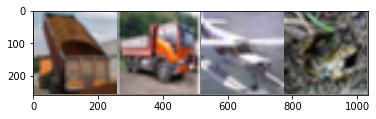

truck truck plane  frog
Wall time: 194 ms


In [67]:
%%time
# plot some example img
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training img
dataiter = iter(trainloader)
imges, labels = dataiter.next()

# show imgs
imshow(torchvision.utils.make_grid(imges))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [68]:
%%time
# load AlexNet pretrained model and modify the last layer to fit
# this dataset which has only 10 classes
model  = torchvision.models.alexnet(pretrained=True)

for prarm in model.parameters():
    prarm.requires_grad = False
    
model.classifier[6] = torch.nn.Linear(4096, 10)

Wall time: 1 s


In [95]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [69]:
%%time
# define a loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.001, 
                            momentum=0.9)

Wall time: 0 ns


In [80]:
%%time

def train_vali_split_loader(trainset, batch_size = 1024, num_workers=0):
    trainset_, valset_ = torch.utils.data.random_split(trainset, 
                              [int(0.8*len(trainset)), 
                               int(0.2*len(trainset))])
    
    trainloader_ = torch.utils.data.DataLoader(trainset_, 
                                              batch_size=batch_size,
                                              shuffle=True, 
                                              num_workers=0)
    
    valiloader_ = torch.utils.data.DataLoader(valset_, 
                                              batch_size=batch_size,
                                              shuffle=True, 
                                              num_workers=0)
    return (trainloader_, valiloader_)



Wall time: 0 ns


In [71]:
%%time
# train the last layer of the model, using batch size 1024, 70 epochs 
batch_size = 1024
accu_train_list = []
accu_vali_list = []
for epoch in range(70):    # loop over the dataset multiple times
    # splite train into train and vali
    trainloader_, valiloader_ = train_vali_split_loader(trainset, batch_size = batch_size)
    
    running_loss = 0.0
    predicted_correct_num_train = 0
    total_train = 0
    for i, data in enumerate(trainloader_, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        batch_num = 3
        running_loss += loss.item()
        if i % batch_num == batch_num-1:      # print every 5 mini-batches
            print('[%d, %5d] loss: %0.3f'%(epoch+1,batch_size*(i+1), 
                  running_loss / batch_num))
            running_loss = 0.0
        
        # training accu
        predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        predicted_correct_num_train += sum(predicted_train.indices == labels)
        
    accu_train = predicted_correct_num_train.item() / total_train
    accu_train_list.append(accu_train)
    
    predicted_correct_num = 0
    total_vali = 0
    # run on vali set to get accuracy
    for i, data in enumerate(valiloader_, 0):
    # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        predicted_vali = torch.max(model(inputs), 1)
        
        total_vali += labels.size(0)
        predicted_correct_num += sum(predicted_vali.indices == labels)
        print("Vali {0} th batch, {1} correct, validated {2}, batch size {3}".format(i, 
                                                                      predicted_correct_num,
                                                                      batch_size*(i+1), batch_size))
        
    accu_vali = predicted_correct_num.item() / total_vali
    accu_vali_list.append(accu_vali)
    
    print("Training Accu: ", accu_train)
    print("Validation Accu: ", accu_vali)
    
print('Finish Traning')

[1,  3072] loss: 2.327
[1,  6144] loss: 2.193
[1,  9216] loss: 2.078
[1, 12288] loss: 1.926
[1, 15360] loss: 1.772
[1, 18432] loss: 1.637
[1, 21504] loss: 1.522
[1, 24576] loss: 1.453
[1, 27648] loss: 1.383
[1, 30720] loss: 1.331
[1, 33792] loss: 1.282
[1, 36864] loss: 1.271
[1, 39936] loss: 1.226
Vali 0 th batch, 612 correct, validated 1024, batch size 1024
Vali 1 th batch, 1202 correct, validated 2048, batch size 1024
Vali 2 th batch, 1809 correct, validated 3072, batch size 1024
Vali 3 th batch, 2476 correct, validated 4096, batch size 1024
Vali 4 th batch, 3097 correct, validated 5120, batch size 1024
Vali 5 th batch, 3715 correct, validated 6144, batch size 1024
Vali 6 th batch, 4306 correct, validated 7168, batch size 1024
Vali 7 th batch, 4914 correct, validated 8192, batch size 1024
Vali 8 th batch, 5543 correct, validated 9216, batch size 1024
Vali 9 th batch, 6013 correct, validated 10240, batch size 1024
Training Accu:  0.45585
Validation Accu:  0.6013
[2,  3072] loss: 1.239

Vali 2 th batch, 2154 correct, validated 3072, batch size 1024
Vali 3 th batch, 2866 correct, validated 4096, batch size 1024
Vali 4 th batch, 3576 correct, validated 5120, batch size 1024
Vali 5 th batch, 4318 correct, validated 6144, batch size 1024
Vali 6 th batch, 5039 correct, validated 7168, batch size 1024
Vali 7 th batch, 5741 correct, validated 8192, batch size 1024
Vali 8 th batch, 6439 correct, validated 9216, batch size 1024
Vali 9 th batch, 6987 correct, validated 10240, batch size 1024
Training Accu:  0.690825
Validation Accu:  0.6987
[10,  3072] loss: 0.902
[10,  6144] loss: 0.913
[10,  9216] loss: 0.915
[10, 12288] loss: 0.839
[10, 15360] loss: 0.865
[10, 18432] loss: 0.867
[10, 21504] loss: 0.874
[10, 24576] loss: 0.868
[10, 27648] loss: 0.863
[10, 30720] loss: 0.853
[10, 33792] loss: 0.872
[10, 36864] loss: 0.865
[10, 39936] loss: 0.885
Vali 0 th batch, 690 correct, validated 1024, batch size 1024
Vali 1 th batch, 1407 correct, validated 2048, batch size 1024
Vali 2 t

Vali 7 th batch, 5800 correct, validated 8192, batch size 1024
Vali 8 th batch, 6524 correct, validated 9216, batch size 1024
Vali 9 th batch, 7094 correct, validated 10240, batch size 1024
Training Accu:  0.711375
Validation Accu:  0.7094
[18,  3072] loss: 0.827
[18,  6144] loss: 0.826
[18,  9216] loss: 0.808
[18, 12288] loss: 0.837
[18, 15360] loss: 0.840
[18, 18432] loss: 0.835
[18, 21504] loss: 0.794
[18, 24576] loss: 0.817
[18, 27648] loss: 0.827
[18, 30720] loss: 0.806
[18, 33792] loss: 0.831
[18, 36864] loss: 0.843
[18, 39936] loss: 0.805
Vali 0 th batch, 713 correct, validated 1024, batch size 1024
Vali 1 th batch, 1427 correct, validated 2048, batch size 1024
Vali 2 th batch, 2166 correct, validated 3072, batch size 1024
Vali 3 th batch, 2884 correct, validated 4096, batch size 1024
Vali 4 th batch, 3606 correct, validated 5120, batch size 1024
Vali 5 th batch, 4327 correct, validated 6144, batch size 1024
Vali 6 th batch, 5033 correct, validated 7168, batch size 1024
Vali 7 t

[26,  9216] loss: 0.787
[26, 12288] loss: 0.805
[26, 15360] loss: 0.827
[26, 18432] loss: 0.800
[26, 21504] loss: 0.819
[26, 24576] loss: 0.813
[26, 27648] loss: 0.808
[26, 30720] loss: 0.781
[26, 33792] loss: 0.790
[26, 36864] loss: 0.789
[26, 39936] loss: 0.763
Vali 0 th batch, 733 correct, validated 1024, batch size 1024
Vali 1 th batch, 1460 correct, validated 2048, batch size 1024
Vali 2 th batch, 2216 correct, validated 3072, batch size 1024
Vali 3 th batch, 2959 correct, validated 4096, batch size 1024
Vali 4 th batch, 3690 correct, validated 5120, batch size 1024
Vali 5 th batch, 4408 correct, validated 6144, batch size 1024
Vali 6 th batch, 5142 correct, validated 7168, batch size 1024
Vali 7 th batch, 5886 correct, validated 8192, batch size 1024
Vali 8 th batch, 6623 correct, validated 9216, batch size 1024
Vali 9 th batch, 7183 correct, validated 10240, batch size 1024
Training Accu:  0.720575
Validation Accu:  0.7183
[27,  3072] loss: 0.801
[27,  6144] loss: 0.791
[27,  92

Vali 1 th batch, 1490 correct, validated 2048, batch size 1024
Vali 2 th batch, 2215 correct, validated 3072, batch size 1024
Vali 3 th batch, 2966 correct, validated 4096, batch size 1024
Vali 4 th batch, 3705 correct, validated 5120, batch size 1024
Vali 5 th batch, 4439 correct, validated 6144, batch size 1024
Vali 6 th batch, 5178 correct, validated 7168, batch size 1024
Vali 7 th batch, 5910 correct, validated 8192, batch size 1024
Vali 8 th batch, 6662 correct, validated 9216, batch size 1024
Vali 9 th batch, 7225 correct, validated 10240, batch size 1024
Training Accu:  0.72335
Validation Accu:  0.7225
[35,  3072] loss: 0.792
[35,  6144] loss: 0.754
[35,  9216] loss: 0.791
[35, 12288] loss: 0.775
[35, 15360] loss: 0.836
[35, 18432] loss: 0.778
[35, 21504] loss: 0.783
[35, 24576] loss: 0.789
[35, 27648] loss: 0.792
[35, 30720] loss: 0.779
[35, 33792] loss: 0.784
[35, 36864] loss: 0.768
[35, 39936] loss: 0.769
Vali 0 th batch, 751 correct, validated 1024, batch size 1024
Vali 1 th

Vali 6 th batch, 5230 correct, validated 7168, batch size 1024
Vali 7 th batch, 5985 correct, validated 8192, batch size 1024
Vali 8 th batch, 6750 correct, validated 9216, batch size 1024
Vali 9 th batch, 7320 correct, validated 10240, batch size 1024
Training Accu:  0.731525
Validation Accu:  0.732
[43,  3072] loss: 0.759
[43,  6144] loss: 0.773
[43,  9216] loss: 0.745
[43, 12288] loss: 0.784
[43, 15360] loss: 0.759
[43, 18432] loss: 0.781
[43, 21504] loss: 0.760
[43, 24576] loss: 0.760
[43, 27648] loss: 0.774
[43, 30720] loss: 0.761
[43, 33792] loss: 0.746
[43, 36864] loss: 0.792
[43, 39936] loss: 0.751
Vali 0 th batch, 737 correct, validated 1024, batch size 1024
Vali 1 th batch, 1477 correct, validated 2048, batch size 1024
Vali 2 th batch, 2217 correct, validated 3072, batch size 1024
Vali 3 th batch, 2950 correct, validated 4096, batch size 1024
Vali 4 th batch, 3688 correct, validated 5120, batch size 1024
Vali 5 th batch, 4431 correct, validated 6144, batch size 1024
Vali 6 th

[51,  3072] loss: 0.739
[51,  6144] loss: 0.746
[51,  9216] loss: 0.757
[51, 12288] loss: 0.779
[51, 15360] loss: 0.753
[51, 18432] loss: 0.725
[51, 21504] loss: 0.740
[51, 24576] loss: 0.786
[51, 27648] loss: 0.766
[51, 30720] loss: 0.743
[51, 33792] loss: 0.757
[51, 36864] loss: 0.766
[51, 39936] loss: 0.772
Vali 0 th batch, 739 correct, validated 1024, batch size 1024
Vali 1 th batch, 1508 correct, validated 2048, batch size 1024
Vali 2 th batch, 2250 correct, validated 3072, batch size 1024
Vali 3 th batch, 3027 correct, validated 4096, batch size 1024
Vali 4 th batch, 3782 correct, validated 5120, batch size 1024
Vali 5 th batch, 4526 correct, validated 6144, batch size 1024
Vali 6 th batch, 5280 correct, validated 7168, batch size 1024
Vali 7 th batch, 6044 correct, validated 8192, batch size 1024
Vali 8 th batch, 6823 correct, validated 9216, batch size 1024
Vali 9 th batch, 7395 correct, validated 10240, batch size 1024
Training Accu:  0.734625
Validation Accu:  0.7395
[52,  30

[59, 36864] loss: 0.757
[59, 39936] loss: 0.772
Vali 0 th batch, 760 correct, validated 1024, batch size 1024
Vali 1 th batch, 1507 correct, validated 2048, batch size 1024
Vali 2 th batch, 2267 correct, validated 3072, batch size 1024
Vali 3 th batch, 3035 correct, validated 4096, batch size 1024
Vali 4 th batch, 3797 correct, validated 5120, batch size 1024
Vali 5 th batch, 4558 correct, validated 6144, batch size 1024
Vali 6 th batch, 5307 correct, validated 7168, batch size 1024
Vali 7 th batch, 6072 correct, validated 8192, batch size 1024
Vali 8 th batch, 6811 correct, validated 9216, batch size 1024
Vali 9 th batch, 7385 correct, validated 10240, batch size 1024
Training Accu:  0.7373
Validation Accu:  0.7385
[60,  3072] loss: 0.746
[60,  6144] loss: 0.718
[60,  9216] loss: 0.735
[60, 12288] loss: 0.747
[60, 15360] loss: 0.791
[60, 18432] loss: 0.799
[60, 21504] loss: 0.733
[60, 24576] loss: 0.758
[60, 27648] loss: 0.748
[60, 30720] loss: 0.739
[60, 33792] loss: 0.762
[60, 36864

Vali 4 th batch, 3816 correct, validated 5120, batch size 1024
Vali 5 th batch, 4566 correct, validated 6144, batch size 1024
Vali 6 th batch, 5343 correct, validated 7168, batch size 1024
Vali 7 th batch, 6111 correct, validated 8192, batch size 1024
Vali 8 th batch, 6891 correct, validated 9216, batch size 1024
Vali 9 th batch, 7483 correct, validated 10240, batch size 1024
Training Accu:  0.741675
Validation Accu:  0.7483
[68,  3072] loss: 0.765
[68,  6144] loss: 0.730
[68,  9216] loss: 0.754
[68, 12288] loss: 0.737
[68, 15360] loss: 0.756
[68, 18432] loss: 0.750
[68, 21504] loss: 0.739
[68, 24576] loss: 0.713
[68, 27648] loss: 0.723
[68, 30720] loss: 0.749
[68, 33792] loss: 0.757
[68, 36864] loss: 0.726
[68, 39936] loss: 0.716
Vali 0 th batch, 760 correct, validated 1024, batch size 1024
Vali 1 th batch, 1502 correct, validated 2048, batch size 1024
Vali 2 th batch, 2234 correct, validated 3072, batch size 1024
Vali 3 th batch, 2965 correct, validated 4096, batch size 1024
Vali 4 t

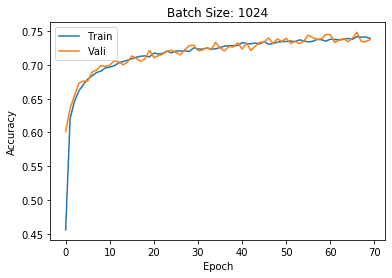

Wall time: 170 ms


In [74]:
%%time
# plot accu with epoch
plt.plot(range(70), accu_train_list, label="Train")
plt.plot(range(70), accu_vali_list, label="Vali")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Batch Size: 1024")
plt.legend()
plt.show()

In [86]:
device

device(type='cpu')

In [89]:
%%time
# train the last layer of the model, using batch size 64, 70 epochs, with cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024
num_workers = 6
model.to(device)
accu_train_list = []
accu_vali_list = []
for epoch in range(1):    # loop over the dataset multiple times
    # splite train into train and vali
    trainloader_, valiloader_ = train_vali_split_loader(trainset, 
                                                        batch_size = batch_size, 
                                                        num_workers=num_workers)
    
    running_loss = 0.0
    predicted_correct_num_train = 0
    total_train = 0
    for i, data in enumerate(trainloader_, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        batch_num = 3
        running_loss += loss.item()
        if i % batch_num == batch_num-1:      # print every 5 mini-batches
            print('[%d, %5d] loss: %0.3f'%(epoch+1,batch_size*(i+1), 
                  running_loss / batch_num))
            running_loss = 0.0
        
        # training accu
        predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        predicted_correct_num_train += sum(predicted_train.indices == labels)
        
    accu_train = predicted_correct_num_train.item() / total_train
    accu_train_list.append(accu_train)
    
    predicted_correct_num = 0
    total_vali = 0
    # run on vali set to get accuracy
    for i, data in enumerate(valiloader_, 0):
    # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        predicted_vali = torch.max(model(inputs), 1)
        
        total_vali += labels.size(0)
        predicted_correct_num += sum(predicted_vali.indices == labels)
        print("Vali {0} th batch, {1} correct, validated {2}, batch size {3}".format(i, 
                                                                      predicted_correct_num,
                                                                      batch_size*(i+1), batch_size))
        
    accu_vali = predicted_correct_num.item() / total_vali
    accu_vali_list.append(accu_vali)
    
    print("Training Accu: ", accu_train)
    print("Validation Accu: ", accu_vali)
    
print('Finish Traning')

[1,  3072] loss: 0.694
[1,  6144] loss: 0.691
[1,  9216] loss: 0.705
[1, 12288] loss: 0.727
[1, 15360] loss: 0.720
[1, 18432] loss: 0.665
[1, 21504] loss: 0.689
[1, 24576] loss: 0.686
[1, 27648] loss: 0.691
[1, 30720] loss: 0.693
[1, 33792] loss: 0.713
[1, 36864] loss: 0.675
[1, 39936] loss: 0.686
Vali 0 th batch, 794 correct, validated 1024, batch size 1024
Vali 1 th batch, 1567 correct, validated 2048, batch size 1024
Vali 2 th batch, 2337 correct, validated 3072, batch size 1024
Vali 3 th batch, 3143 correct, validated 4096, batch size 1024
Vali 4 th batch, 3921 correct, validated 5120, batch size 1024
Vali 5 th batch, 4654 correct, validated 6144, batch size 1024
Vali 6 th batch, 5422 correct, validated 7168, batch size 1024
Vali 7 th batch, 6196 correct, validated 8192, batch size 1024
Vali 8 th batch, 6981 correct, validated 9216, batch size 1024
Vali 9 th batch, 7567 correct, validated 10240, batch size 1024
Training Accu:  0.754475
Validation Accu:  0.7567
Finish Traning
Wall t

In [ ]:
%%time
# plot accu with epoch
plt.plot(range(70), accu_train_list, label="Train")
plt.plot(range(70), accu_vali_list, label="Vali")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Batch Size: 64")
plt.legend()
plt.show()

In [ ]:
%%time
# train the last layer of the model, using batch size 64, 70 epochs, with cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024
num_workers = 6
model.to(device)
accu_train_list = []
accu_vali_list = []
for epoch in range(1):    # loop over the dataset multiple times
    # splite train into train and vali
    trainloader_, valiloader_ = train_vali_split_loader(trainset, 
                                                        batch_size = batch_size, 
                                                        num_workers=num_workers)
    
    running_loss = 0.0
    predicted_correct_num_train = 0
    total_train = 0
    for i, data in enumerate(trainloader_, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        batch_num = 3
        running_loss += loss.item()
        if i % batch_num == batch_num-1:      # print every 5 mini-batches
            print('[%d, %5d] loss: %0.3f'%(epoch+1,batch_size*(i+1), 
                  running_loss / batch_num))
            running_loss = 0.0
        
        # training accu
        predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        predicted_correct_num_train += sum(predicted_train.indices == labels)
        
    accu_train = predicted_correct_num_train.item() / total_train
    accu_train_list.append(accu_train)
    
    predicted_correct_num = 0
    total_vali = 0
    # run on vali set to get accuracy
    for i, data in enumerate(valiloader_, 0):
    # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        predicted_vali = torch.max(model(inputs), 1)
        
        total_vali += labels.size(0)
        predicted_correct_num += sum(predicted_vali.indices == labels)
        print("Vali {0} th batch, {1} correct, validated {2}, batch size {3}".format(i, 
                                                                      predicted_correct_num,
                                                                      batch_size*(i+1), batch_size))
        
    accu_vali = predicted_correct_num.item() / total_vali
    accu_vali_list.append(accu_vali)
    
    print("Training Accu: ", accu_train)
    print("Validation Accu: ", accu_vali)
    
print('Finish Traning')

In [94]:
# test accuracy with test dataset
batch_size = 1024
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
predicted_correct_num = 0
total_vali = 0
for i, data in  enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        predicted_vali = torch.max(model(inputs), 1)
        
        total_vali += labels.size(0)
        predicted_correct_num += sum(predicted_vali.indices == labels)
        print("Vali {0} th batch, {1} correct, validated {2}, batch size {3}".format(i, 
                                                                      predicted_correct_num,
                                                                      batch_size*(i+1), batch_size))
        
accu_vali = predicted_correct_num.item() / total_vali    
    
print("Test Accu: ", accu_vali)

Files already downloaded and verified
Vali 0 th batch, 734 correct, validated 1024, batch size 1024
Vali 1 th batch, 1497 correct, validated 2048, batch size 1024
Vali 2 th batch, 2262 correct, validated 3072, batch size 1024
Vali 3 th batch, 3002 correct, validated 4096, batch size 1024
Vali 4 th batch, 3792 correct, validated 5120, batch size 1024
Vali 5 th batch, 4524 correct, validated 6144, batch size 1024
Vali 6 th batch, 5279 correct, validated 7168, batch size 1024
Vali 7 th batch, 6036 correct, validated 8192, batch size 1024
Vali 8 th batch, 6812 correct, validated 9216, batch size 1024
Vali 9 th batch, 7396 correct, validated 10240, batch size 1024
Test Accu:  0.7396
